In [11]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Generate Hamiltonian

In [12]:
nqubits = 3

# target_weights = [0.5, 0.8]
# H_target = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights)

min_w = -1
max_w = 1
H_target, target_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qilisdk')


print("Target Hamilonian: \n", H_target.H, "\n")
print("Target weights:", target_weights)

Target Hamilonian: 
 0.1295405343078948 X(0) - 0.14110621630336584 Z(0) - 0.9568938123210247 Z(0) Z(1) - 0.7724237410566697 Z(0) Z(2) + 0.6868980454200182 X(1) - 0.7656630597780303 Z(1) + 0.40942693293033905 Z(1) Z(2) - 0.9093075726775552 X(2) - 0.3409526048831526 Z(2) 

Target weights: [ 0.12954053  0.68689805 -0.90930757 -0.14110622 -0.76566306 -0.3409526
 -0.95689381 -0.77242374  0.40942693]


## Create target trajectory

In [13]:
ti = 0
times = np.linspace(0.01, 3, 20)

initial_zero_state = tensor_prod([ket(0).unit() for _ in range(nqubits)]).unit()
#initial_minus_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()

Hx = sum(X(i) for i in range(nqubits)) #Driver

target_states = []
target_x, target_z = [], []

for T in times:
    dt = T/100
    steps = np.linspace(0, T, int(T / dt))
    
    sim = VQE.simulate_annealing(T, dt, steps, Hx, H_target.H, initial_zero_state)

    #save expectation values
    target_x.append(sim.final_expected_values[0])
    target_z.append(sim.final_expected_values[2])

    #save final state as qutip object
    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    target_states.append(target_qutip_state)

In [14]:
# Define Hamiltonians
initial_weights = np.random.uniform(min_w, max_w, size=(2*nqubits + int(nqubits*(nqubits-1)/2)))

options={
    'maxiter': 2000,           # Increase iterations
    'ftol': 1e-10,            # Function tolerance
    'gtol': 1e-8,             # Gradient tolerance  
    'maxfun': 10000,          # Max function evaluations
    'disp': True              # Print convergence messages
    }

final_result = VQE.learn_hamiltonian(nqubits, initial_weights, Hx, initial_zero_state, target_states, times, options, mode = "segmented")

Initial weights: [-0.74428262  0.46180682  0.96322841 -0.32052442 -0.01391073  0.53211592
 -0.18403175 -0.27138463 -0.5173819 ]
Updated weights: [-0.74428262  0.46180682  0.96322841 -0.32052442 -0.01391073  0.53211592
 -0.18403175 -0.27138463 -0.5173819 ]
Updated weights: [ 0.070651    0.66737494 -0.83977452 -0.32769566 -0.03237298  0.52082393
 -0.20957942 -0.2897869  -0.54643268]
Updated weights: [ 0.11431783  0.69503876 -0.91849103 -0.55739203 -0.17821387  0.50168301
 -0.58971343 -0.53788744 -0.70197304]
Updated weights: [ 0.13357866  0.67654275 -0.92283005 -0.55506827 -0.04250138  0.44187215
 -0.73550453 -0.60425314 -0.50153056]
Updated weights: [ 0.12822694  0.68693778 -0.90083263 -0.02558454 -0.71723446 -0.24951394
 -0.9522709  -0.89795753  0.36348348]
Updated weights: [ 0.1300618   0.68601654 -0.90211631 -0.02491187 -0.7208016  -0.24792384
 -0.95538567 -0.89308051  0.36300137]
Updated weights: [ 0.13121362  0.68661517 -0.91155579 -0.13039642 -0.77126896 -0.31681187
 -0.9584111  -

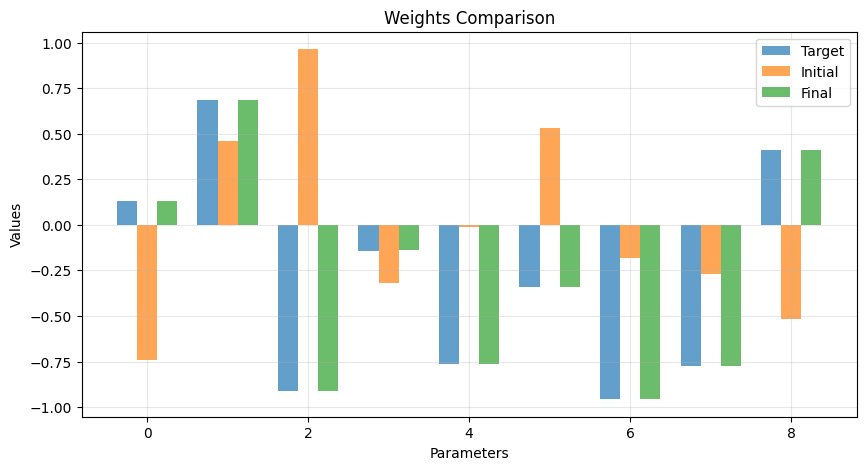

In [15]:
final_weights = final_result.x
plots.plot_weights(target_weights, initial_weights, final_weights)